In [257]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from IPython.display import display, Markdown, Latex
from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib.pyplot as plt

# 1.0 Chargement et prétraitement des données

### Chargement

Le données proviennent de [ce dépôt.](https://www.kaggle.com/datasets/mathieugodbout/oct-postsurgery-visual-improvement)

L'ensemble de test ne sera jamais employé dans aucune étape d'entraînement.  Par-contre, pour la régression logistique, l'ensemble de validation et l'ensemble d'entraînement seront fusionnés.

### Prétraitement

- Les données manquantes seront remplacées par la moyenne de la variable.
- Le sexe est codé comme 1-2. Il sera recodé comme 0-1 afin que toutes les variables soient mises à la même échelle.
- Lors des étapes d'entraînement on va normaliser les variables numériques selon leur score Z afin qu'elles soient toutes N(0, 1).

## 1.1 Statistiques de l'ensemble d'entraînement (pour la régression logistique) vs l'ensemble test

In [258]:
chemin = "~/PycharmProjects/trou_maculaire_regression_logistique/data/"

def get_data_from_files(chemin, fname):
    df = pd.DataFrame()
    for name in fname:
        file = chemin + name
        df = pd.concat([df, pd.read_csv(file)])

    df.drop(['id', 'VA_2weeks', 'VA_3months', 'VA_12months'], inplace=True, axis=1)

    df['VA_baseline'].replace(0, np.nan, inplace=True)
    df['VA_baseline'].fillna(df['VA_baseline'].mean(), inplace=True)

    df.replace(-9, np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)

    df['responder'] = (df['VA_6months'] - df['VA_baseline']) >= 15


    return df

df_test = get_data_from_files(chemin, ["clinical_data_test.csv"])
display(Markdown(df_test.to_markdown()))

|    |   age |   sex |   pseudophakic |   mh_duration |   elevated_edge |   mh_size |   VA_baseline |   VA_6months | responder   |
|---:|------:|------:|---------------:|--------------:|----------------:|----------:|--------------:|-------------:|:------------|
|  0 |    60 |     2 |              0 |        9      |               0 |       252 |            54 |           71 | True        |
|  1 |    68 |     2 |              1 |       10.3125 |               0 |       336 |            41 |           78 | True        |
|  2 |    73 |     1 |              0 |        5      |               1 |       287 |            43 |           76 | True        |
|  3 |    70 |     1 |              1 |        3      |               1 |       144 |            56 |           80 | True        |
|  4 |    68 |     2 |              1 |        9      |               1 |       152 |            63 |           83 | True        |
|  5 |    66 |     2 |              0 |       10      |               0 |       160 |            63 |           69 | False       |
|  6 |    62 |     2 |              0 |       13      |               1 |       184 |            36 |           37 | False       |
|  7 |    83 |     2 |              0 |       10      |               1 |       355 |            59 |           63 | False       |
|  8 |    72 |     1 |              1 |       21      |               1 |       191 |            68 |           62 | False       |
|  9 |    65 |     2 |              0 |        9      |               1 |       240 |            41 |           52 | False       |
| 10 |    69 |     2 |              0 |       16      |               1 |       212 |            69 |           49 | False       |
| 11 |    80 |     1 |              0 |       13      |               1 |       248 |            65 |           72 | False       |
| 12 |    63 |     2 |              0 |        8      |               1 |       216 |            62 |           71 | False       |
| 13 |    76 |     1 |              0 |        8      |               1 |       144 |            75 |           70 | False       |
| 14 |    58 |     2 |              0 |        4      |               0 |       288 |            43 |           63 | True        |
| 15 |    74 |     2 |              0 |       15      |               1 |       520 |            40 |           63 | True        |
| 16 |    63 |     2 |              0 |       12      |               1 |       424 |            40 |           63 | True        |

### 1.1.1 Vue d'ensemble des données de l'ensemble test, après prétraitement

In [259]:
def get_continuous_data_descriptive_stats(df):
    """
    Construit un dataframe décrivant la moyenne et l'écart-type des variables continues du modèle clinique
    :param df: df d'entrainement ou de test fourni sur Kaggle par Mathieu Godbout
    :return: Un dataframe 5X2 contenant une colonne des moyennes et une colonne des écarts-type pour l'âge, la durée, le diamètre du trou, l'acuité visuelle de base et l'acuité visuelle à 6 mois.
    """
    df_cont = df.drop(['sex', 'pseudophakic', 'elevated_edge', 'responder'], axis=1)
    stats_cont = pd.DataFrame([df_cont.mean(axis=0, skipna=True), df_cont.std(axis=0, skipna=True)]).transpose()
    stats_cont.columns = ['Mean', 'SDev']
    stats_cont = stats_cont.round(decimals=0)
    return stats_cont


test_set_continuous_data_descriptive_stats = get_continuous_data_descriptive_stats(df_test)
display(Markdown(test_set_continuous_data_descriptive_stats.to_markdown()))


|             |   Mean |   SDev |
|:------------|-------:|-------:|
| age         |     69 |      7 |
| mh_duration |     10 |      4 |
| mh_size     |    256 |    104 |
| VA_baseline |     54 |     13 |
| VA_6months  |     66 |     12 |

### Résultats de la table 1, pour l'ensemble test et les données numériques

- Il y a une différence de 1 dans la SD de mh_duration par-rapport aux résultats de l'article
- On a 54 pour VA_baseline alors que dans l'article la valeur de 51 est rapportée.  Toutefois, une des valeurs de ce set était 0.  Est-ce une observation clinique adéquate ou une donnée manquante ayant été mal saisie?  Ici nous l'avons remplacée par la moyenne.

In [260]:
df_test_cat = df_test.drop(['age', 'VA_baseline', 'VA_6months', 'mh_duration', 'mh_size'], axis=1)

def get_categorical_variable_descriptive_stats(df_cat, col_name, cmap):
    cat_stats = df_cat[col_name].value_counts()
    cat_stats.rename(cmap, inplace=True)
    cat_stats.rename('number', inplace=True)
    cat_proportions = df_cat[col_name].value_counts(normalize=True)*100
    cat_proportions.rename(cmap, inplace=True)
    cat_proportions.rename('per_cent', inplace=True)
    cat_stats = pd.concat([cat_stats, cat_proportions], axis=1)
    cat_stats = cat_stats.round(decimals=0)
    return cat_stats

def get_categorical_data_descriptive_stats(df_cat):
    return pd.concat([get_categorical_variable_descriptive_stats(df_cat, 'sex', {1:'M', 2:'F'}),
                      get_categorical_variable_descriptive_stats(df_cat, 'pseudophakic', {0:'lens_absent', 1:'lens_present'}),
                      get_categorical_variable_descriptive_stats(df_cat, 'elevated_edge', {0:'no_elevated_edge', 1:'elevated_edge'}),
                      get_categorical_variable_descriptive_stats(df_cat, 'responder', {0:'non_responder', 1:'responder'})
        
    ])

test_set_categorical_data_stats = get_categorical_data_descriptive_stats(df_test_cat)
display(Markdown(test_set_categorical_data_stats.to_markdown()))

|                  |   number |   per_cent |
|:-----------------|---------:|-----------:|
| F                |       12 |         71 |
| M                |        5 |         29 |
| lens_absent      |       13 |         76 |
| lens_present     |        4 |         24 |
| elevated_edge    |       13 |         76 |
| no_elevated_edge |        4 |         24 |
| non_responder    |        9 |         53 |
| responder        |        8 |         47 |

### Résultats de la table 1 pour les données catégoriques de l'ensemble test

- On a correspondance pour le sexe, la présence d'une lentille implantée, et le nombre de répondeurs.
- La catégorie "rebord élevé" n'apparait pas dans l'article alors qu'elle est dans le modèle clinique.  Pourquoi?

In [261]:
df_train_lr = get_data_from_files(chemin, ['clinical_data_train.csv', 'clinical_data_val.csv'])
print(len(df_train_lr))

104


In [262]:
display(Markdown(df_train_lr.to_markdown()))

|    |   age |   sex |   pseudophakic |   mh_duration |   elevated_edge |   mh_size |   VA_baseline |   VA_6months | responder   |
|---:|------:|------:|---------------:|--------------:|----------------:|----------:|--------------:|-------------:|:------------|
|  0 |    73 |     2 |              0 |        3      |        1        |       336 |            58 |           78 | True        |
|  1 |    69 |     2 |              0 |       47      |        1        |       552 |            33 |           71 | True        |
|  2 |    67 |     2 |              0 |        8      |        1        |       761 |            10 |           77 | True        |
|  3 |    56 |     2 |              0 |        9      |        1        |       467 |            42 |           77 | True        |
|  4 |    49 |     2 |              0 |        7      |        1        |       320 |            61 |           83 | True        |
|  5 |    61 |     1 |              0 |        8      |        1        |       153 |            66 |           83 | True        |
|  6 |    77 |     1 |              1 |        7      |        1        |       518 |            53 |           74 | True        |
|  7 |    79 |     2 |              1 |       11      |        1        |       671 |            53 |           78 | True        |
|  8 |    69 |     2 |              1 |        7      |        1        |       264 |            48 |           78 | True        |
|  9 |    72 |     2 |              0 |       19      |        1        |       133 |            58 |           75 | True        |
| 10 |    62 |     2 |              1 |        4      |        1        |       645 |            35 |           78 | True        |
| 11 |    55 |     2 |              1 |        9      |        1        |       411 |            48 |           78 | True        |
| 12 |    65 |     2 |              0 |       21      |        1        |       378 |            48 |           75 | True        |
| 13 |    66 |     1 |              0 |       11.1782 |        1        |       319 |            63 |           78 | True        |
| 14 |    50 |     1 |              0 |       12      |        1        |       240 |            58 |           80 | True        |
| 15 |    64 |     2 |              0 |        7      |        1        |       352 |            59 |           80 | True        |
| 16 |    69 |     2 |              1 |        2      |        1        |       289 |            59 |           74 | True        |
| 17 |    66 |     2 |              0 |        7      |        1        |       208 |            52 |           74 | True        |
| 18 |    58 |     2 |              0 |        4      |        0        |        88 |            49 |           70 | True        |
| 19 |    48 |     2 |              0 |        7      |        1        |       808 |            36 |           78 | True        |
| 20 |    68 |     2 |              0 |       18      |        1        |       208 |            52 |           70 | True        |
| 21 |    72 |     2 |              0 |        4      |        1        |       363 |            36 |           80 | True        |
| 22 |    90 |     1 |              0 |       17      |        1        |       451 |            41 |           78 | True        |
| 23 |    65 |     2 |              0 |       12      |        1        |       230 |            58 |           74 | True        |
| 24 |    78 |     1 |              0 |        7      |        1        |       108 |            63 |           68 | False       |
| 25 |    61 |     2 |              0 |        9      |        1        |       368 |            53 |           56 | False       |
| 26 |    76 |     2 |              0 |       11      |        1        |       183 |            63 |           50 | False       |
| 27 |    66 |     2 |              0 |       10      |        1        |       262 |            57 |           59 | False       |
| 28 |    73 |     1 |              0 |        7      |        1        |       248 |            50 |           63 | False       |
| 29 |    70 |     2 |              0 |       11      |        1        |       376 |            59 |           64 | False       |
| 30 |    68 |     2 |              0 |       12      |        1        |       342 |            62 |           65 | False       |
| 31 |    60 |     2 |              0 |       39      |        1        |       512 |            43 |           48 | False       |
| 32 |    60 |     1 |              0 |       18      |        0        |       232 |            79 |           10 | False       |
| 33 |    67 |     2 |              0 |        4      |        1        |       143 |            66 |           67 | False       |
| 34 |    64 |     2 |              0 |       10      |        1        |       112 |            68 |           67 | False       |
| 35 |    64 |     2 |              0 |        8      |        1        |       162 |            49 |           58 | False       |
| 36 |    66 |     1 |              1 |        8      |        0        |       157 |            57 |           63 | False       |
| 37 |    60 |     1 |              0 |       13      |        1        |       176 |            65 |           67 | False       |
| 38 |    70 |     1 |              0 |       10      |        1        |       433 |            51 |           56 | False       |
| 39 |    65 |     2 |              0 |        5      |        1        |       496 |            57 |           51 | False       |
| 40 |    62 |     2 |              0 |        5      |        1        |       435 |            64 |           63 | False       |
| 41 |    56 |     1 |              0 |        8      |        1        |       316 |            48 |           56 | False       |
| 42 |    64 |     2 |              0 |        8      |        0        |       248 |            43 |           51 | False       |
| 43 |    67 |     2 |              0 |       18      |        0        |       202 |            36 |           41 | False       |
| 44 |    73 |     2 |              0 |        9      |        0        |       264 |            62 |           69 | False       |
| 45 |    66 |     2 |              0 |        4      |        1        |       316 |            51 |           36 | False       |
| 46 |    68 |     2 |              0 |       17      |        1        |       465 |            49 |           60 | False       |
| 47 |    64 |     2 |              0 |       12      |        1        |       208 |            56 |           63 | False       |
| 48 |    67 |     2 |              0 |        7      |        1        |       434 |            50 |           43 | False       |
| 49 |    62 |     2 |              0 |       12      |        1        |       539 |            36 |           50 | False       |
| 50 |    73 |     1 |              1 |       11      |        1        |       160 |            60 |           68 | False       |
| 51 |    71 |     2 |              0 |        7      |        1        |       380 |            49 |           60 | False       |
| 52 |    66 |     2 |              0 |       13      |        1        |       425 |            60 |           70 | False       |
| 53 |    56 |     2 |              0 |        6      |        1        |       176 |            70 |           78 | False       |
| 54 |    82 |     1 |              0 |        6      |        1        |       229 |            65 |           70 | False       |
| 55 |    68 |     1 |              0 |        6      |        1        |        80 |            63 |           76 | False       |
| 56 |    67 |     2 |              0 |       13      |        0        |       189 |            70 |           71 | False       |
| 57 |    66 |     2 |              0 |        2      |        1        |        96 |            65 |           76 | False       |
| 58 |    39 |     2 |              1 |        6      |        1        |       280 |            65 |           76 | False       |
| 59 |    71 |     2 |              1 |        3      |        1        |       400 |            79 |           80 | False       |
| 60 |    74 |     2 |              0 |        6      |        1        |       440 |            68 |           72 | False       |
| 61 |    69 |     1 |              0 |       11.1782 |        1        |       207 |            60 |           70 | False       |
| 62 |    69 |     2 |              0 |        4      |        0.901961 |       270 |            65 |           70 | False       |
| 63 |    63 |     1 |              0 |       21      |        1        |       240 |            63 |           70 | False       |
| 64 |    67 |     1 |              1 |       12      |        1        |       474 |            70 |           71 | False       |
| 65 |    73 |     1 |              0 |       13      |        1        |       223 |            63 |           75 | False       |
| 66 |    70 |     2 |              0 |        5      |        1        |       498 |            40 |           65 | True        |
| 67 |    57 |     1 |              0 |       24      |        1        |       592 |            10 |           63 | True        |
| 68 |    66 |     2 |              0 |        8      |        1        |       122 |            40 |           69 | True        |
| 69 |    67 |     2 |              0 |       10      |        1        |       712 |            10 |           53 | True        |
| 70 |    72 |     2 |              0 |        9      |        1        |       696 |            43 |           59 | True        |
| 71 |    65 |     2 |              0 |        7      |        1        |       288 |            34 |           57 | True        |
| 72 |    64 |     2 |              0 |        2      |        1        |       240 |            40 |           61 | True        |
| 73 |    69 |     2 |              0 |       15      |        1        |       572 |            43 |           67 | True        |
| 74 |    78 |     2 |              1 |        7      |        0        |       387 |            43 |           67 | True        |
| 75 |    69 |     2 |              1 |       75      |        1        |       627 |            10 |           60 | True        |
| 76 |    63 |     2 |              0 |       16      |        1        |       672 |            43 |           69 | True        |
| 77 |    70 |     2 |              0 |        9      |        1        |       568 |            41 |           64 | True        |
| 78 |    64 |     2 |              0 |        7      |        1        |       486 |            21 |           69 | True        |
| 79 |    66 |     2 |              0 |        4      |        1        |       344 |            40 |           59 | True        |
| 80 |    78 |     1 |              1 |        9      |        1        |       368 |            21 |           50 | True        |
| 81 |    77 |     2 |              0 |       24      |        1        |       486 |            10 |           41 | True        |
| 82 |    69 |     2 |              0 |       38      |        1        |       513 |            49 |           68 | True        |
|  0 |    67 |     1 |              0 |        5      |        1        |       240 |            49 |           72 | True        |
|  1 |    64 |     1 |              0 |       10      |        1        |       168 |            58 |           76 | True        |
|  2 |    64 |     2 |              0 |        6      |        1        |       376 |            48 |           70 | True        |
|  3 |    76 |     2 |              1 |        5      |        1        |       302 |            58 |           78 | True        |
|  4 |    62 |     1 |              0 |        8      |        1        |       325 |            40 |           70 | True        |
|  5 |    55 |     2 |              0 |       14      |        1        |       164 |            61 |           79 | True        |
|  6 |    65 |     2 |              0 |       24      |        1        |       527 |            47 |           49 | False       |
|  7 |    65 |     2 |              0 |       10      |        1        |       437 |            48 |           60 | False       |
|  8 |    75 |     1 |              0 |        8      |        1        |       476 |            36 |           50 | False       |
|  9 |    61 |     2 |              0 |       16      |        1        |       432 |            63 |           69 | False       |
| 10 |    68 |     1 |              0 |       11.1782 |        1        |       682 |            57 |           52 | False       |
| 11 |    59 |     2 |              0 |       12      |        1        |       365 |            58 |           63 | False       |
| 12 |    60 |     2 |              0 |        8      |        0        |       248 |            72 |           63 | False       |
| 13 |    69 |     2 |              1 |        6      |        1        |       253 |            60 |           74 | False       |
| 14 |    60 |     1 |              0 |       12      |        0        |       258 |            57 |           70 | False       |
| 15 |    47 |     2 |              0 |       13      |        1        |       224 |            66 |           76 | False       |
| 16 |    61 |     2 |              1 |        9      |        1        |       617 |            20 |           67 | True        |
| 17 |    72 |     2 |              0 |       11      |        0.901961 |       604 |            36 |           61 | True        |
| 18 |    78 |     1 |              1 |        9      |        1        |       154 |            40 |           60 | True        |
| 19 |    67 |     2 |              0 |        8      |        1        |       648 |            21 |           50 | True        |
| 20 |    74 |     2 |              0 |        5      |        1        |       294 |            41 |           58 | True        |

### Vue d'ensemble des données pour l'ensemble d'entraînement de la régression logistique
- On voit qu'il manquait deux données dans la catégorie elevated_edge.  Elles ont été remplacées par la 'moyenne'.  Est-ce adéquat?  Cela pose des problèmes lorsqu'on tente d'extraire les statistiques descriptives des variables catégoriques.

In [263]:
train_set_continuous_data_stats = get_continuous_data_descriptive_stats(df_train_lr)
display(Markdown(train_set_continuous_data_stats.to_markdown()))

|             |   Mean |   SDev |
|:------------|-------:|-------:|
| age         |     66 |      8 |
| mh_duration |     11 |     10 |
| mh_size     |    357 |    172 |
| VA_baseline |     50 |     15 |
| VA_6months  |     66 |     12 |

### Résultats de la table 1 pour les variables numériques de l'ensemble d'entraînement de la régression logistique

- Les résultats de l'article sont reproduits

In [264]:
train_set_categorical_data_stats = get_categorical_data_descriptive_stats(df_train_lr)
display(Markdown(train_set_categorical_data_stats.to_markdown()))

|                    |   number |   per_cent |
|:-------------------|---------:|-----------:|
| F                  |       76 |         73 |
| M                  |       28 |         27 |
| lens_absent        |       86 |         83 |
| lens_present       |       18 |         17 |
| elevated_edge      |       92 |         88 |
| no_elevated_edge   |       10 |         10 |
| 0.9019607843137255 |        2 |          2 |
| responder          |       52 |         50 |
| non_responder      |       52 |         50 |

### Résultats de la table 1 pour les données catégoriques de l'ensemble d'entraînement

- Une fausse catégorie est apparue car des variables elevated_edge absentes ont été remplacées par la moyenne


In [265]:
total_set = pd.concat([df_train_lr, df_test])
print(len(total_set))

121


### 1.1.2 Statistiques de l'ensemble total et comparaison entre répondeurs et non-répondeurs

In [266]:
total_set_continuous_data_stats = get_continuous_data_descriptive_stats(total_set)
display(Markdown(total_set_continuous_data_stats.to_markdown()))

|             |   Mean |   SDev |
|:------------|-------:|-------:|
| age         |     67 |      8 |
| mh_duration |     11 |      9 |
| mh_size     |    343 |    167 |
| VA_baseline |     51 |     15 |
| VA_6months  |     66 |     12 |

### Résultats de la table 1 pour les données numériques de l'ensemble total

- Une anomalie semble s'être glissée dans l'écart-type de l'âge

In [267]:
total_set_categorical_data_stats = get_categorical_data_descriptive_stats(total_set)
display(Markdown(total_set_categorical_data_stats.to_markdown()))

|                    |   number |   per_cent |
|:-------------------|---------:|-----------:|
| F                  |       88 |         73 |
| M                  |       33 |         27 |
| lens_absent        |       99 |         82 |
| lens_present       |       22 |         18 |
| elevated_edge      |      105 |         87 |
| no_elevated_edge   |       14 |         12 |
| 0.9019607843137255 |        2 |          2 |
| non_responder      |       61 |         50 |
| responder          |       60 |         50 |

### Résultats de la table 1 pour les données catégoriques de l'ensemble total

- Présence de la même anomalie pour la catégorie elevated_edge

In [268]:
total_set_non_responder, total_set_responder = [x for _, x in total_set.groupby(total_set['responder'])]

responders_continuous_data_stats = get_continuous_data_descriptive_stats(total_set_responder)
responders_continuous_data_stats.rename({'Mean': 'Mean_resp', 'SDev': 'SD_resp'}, axis=1, inplace=True)
non_responders_continuous_data_stats = get_continuous_data_descriptive_stats(total_set_non_responder)
non_responders_continuous_data_stats.rename({'Mean': 'Mean_nonresp', 'SDev': 'SD_nonresp'}, axis=1, inplace=True)

rvsnonr_continuous_data_stats = pd.concat([responders_continuous_data_stats, non_responders_continuous_data_stats], axis=1)
display(Markdown(rvsnonr_continuous_data_stats.to_markdown()))

|             |   Mean_resp |   SD_resp |   Mean_nonresp |   SD_nonresp |
|:------------|------------:|----------:|---------------:|-------------:|
| age         |          67 |         8 |             66 |            7 |
| mh_duration |          11 |        11 |             11 |            6 |
| mh_size     |         394 |       185 |            293 |          132 |
| VA_baseline |          43 |        15 |             59 |           10 |
| VA_6months  |          70 |         9 |             62 |           12 |

### Table 2: Comparaison des répondeurs vs non-répondeurs pour les variables numériques

- L'écart-type pour l'âge dans l'article semble avoir spontanément été multiplié par deux

In [269]:
responders_categorical_data_stats = get_categorical_data_descriptive_stats(total_set_responder)
responders_categorical_data_stats.rename({'Mean': 'Mean_resp', 'SDev': 'SD_resp'}, axis=1, inplace=True)
nonresponders_categorical_data_stats = get_categorical_data_descriptive_stats(total_set_non_responder)
nonresponders_categorical_data_stats.rename({'Mean': 'Mean_nonresp', 'SDev': 'SD_nonresp'}, axis=1, inplace=True)
rvsnr_categorical_data_stats = pd.concat([responders_categorical_data_stats, nonresponders_categorical_data_stats], axis=1)
display(Markdown(rvsnr_categorical_data_stats.to_markdown()))

|                    |   number |   per_cent |   number |   per_cent |
|:-------------------|---------:|-----------:|---------:|-----------:|
| F                  |       47 |         78 |       41 |         67 |
| M                  |       13 |         22 |       20 |         33 |
| lens_absent        |       45 |         75 |       54 |         89 |
| lens_present       |       15 |         25 |        7 |         11 |
| elevated_edge      |       54 |         90 |       51 |         84 |
| no_elevated_edge   |        5 |          8 |        9 |         15 |
| 0.9019607843137255 |        1 |          2 |        1 |          2 |
| responder          |       60 |        100 |      nan |        nan |
| non_responder      |      nan |        nan |       61 |        100 |

### Table 2 comparaison des répondeurs vs non-répondeurs pour les données catégoriques

# 2.0 Expérience de régression logistique sur l'ensemble d'entraînement

## 2.1 Normalisation des données et définition des variables dépendantes et indépendantes

In [270]:
def normalise_data(df):
    for variable in ['mh_duration', 'mh_size', 'VA_baseline']:
        moy = df[variable].mean()
        std = df[variable].std()
        df[variable] = (df[variable] - moy) / std

# Préparation des données
X = df_train_lr.copy().drop(['responder', 'age', 'sex', 'VA_6months', 'elevated_edge'], axis=1)
normalise_data(X)
y = df_train_lr['responder'].copy()

display(Markdown(X.to_markdown()))
display(Markdown(y.to_markdown()))

|    |   pseudophakic |   mh_duration |    mh_size |   VA_baseline |
|---:|---------------:|--------------:|-----------:|--------------:|
|  0 |              0 |    -0.853865  | -0.122651  |     0.512052  |
|  1 |              0 |     3.74005   |  1.13429   |    -1.13157   |
|  2 |              0 |    -0.331829  |  2.3505    |    -2.64371   |
|  3 |              0 |    -0.227422  |  0.639663  |    -0.539867  |
|  4 |              0 |    -0.436236  | -0.215757  |     0.709287  |
|  5 |              0 |    -0.331829  | -1.18756   |     1.03801   |
|  6 |              1 |    -0.436236  |  0.936441  |     0.183327  |
|  7 |              1 |    -0.0186072 |  1.82678   |     0.183327  |
|  8 |              1 |    -0.436236  | -0.541632  |    -0.145398  |
|  9 |              0 |     0.81665   | -1.30395   |     0.512052  |
| 10 |              1 |    -0.749458  |  1.67548   |    -1.00008   |
| 11 |              1 |    -0.227422  |  0.313788  |    -0.145398  |
| 12 |              0 |     1.02546   |  0.121755  |    -0.145398  |
| 13 |              0 |     0         | -0.221577  |     0.840777  |
| 14 |              0 |     0.0858    | -0.681292  |     0.512052  |
| 15 |              0 |    -0.436236  | -0.0295436 |     0.577797  |
| 16 |              1 |    -0.958272  | -0.396152  |     0.577797  |
| 17 |              0 |    -0.436236  | -0.867506  |     0.117582  |
| 18 |              0 |    -0.749458  | -1.56581   |    -0.0796526 |
| 19 |              0 |    -0.436236  |  2.624     |    -0.934337  |
| 20 |              0 |     0.712243  | -0.867506  |     0.117582  |
| 21 |              0 |    -0.749458  |  0.0344675 |    -0.934337  |
| 22 |              0 |     0.607836  |  0.546556  |    -0.605612  |
| 23 |              0 |     0.0858    | -0.739484  |     0.512052  |
| 24 |              0 |    -0.436236  | -1.44942   |     0.840777  |
| 25 |              0 |    -0.227422  |  0.0635634 |     0.183327  |
| 26 |              0 |    -0.0186072 | -1.01299   |     0.840777  |
| 27 |              0 |    -0.123014  | -0.55327   |     0.446307  |
| 28 |              0 |    -0.436236  | -0.634739  |    -0.0139076 |
| 29 |              0 |    -0.0186072 |  0.110117  |     0.577797  |
| 30 |              0 |     0.0858    | -0.0877354 |     0.775032  |
| 31 |              0 |     2.90479   |  0.901526  |    -0.474122  |
| 32 |              0 |     0.712243  | -0.727846  |     1.8927    |
| 33 |              0 |    -0.749458  | -1.24575   |     1.03801   |
| 34 |              0 |    -0.123014  | -1.42615   |     1.1695    |
| 35 |              0 |    -0.331829  | -1.13519   |    -0.0796526 |
| 36 |              1 |    -0.331829  | -1.16428   |     0.446307  |
| 37 |              0 |     0.190207  | -1.05372   |     0.972267  |
| 38 |              0 |    -0.123014  |  0.44181   |     0.0518374 |
| 39 |              0 |    -0.64505   |  0.808419  |     0.446307  |
| 40 |              0 |    -0.64505   |  0.453449  |     0.906522  |
| 41 |              0 |    -0.331829  | -0.239034  |    -0.145398  |
| 42 |              0 |    -0.331829  | -0.634739  |    -0.474122  |
| 43 |              0 |     0.712243  | -0.902421  |    -0.934337  |
| 44 |              0 |    -0.227422  | -0.541632  |     0.775032  |
| 45 |              0 |    -0.749458  | -0.239034  |     0.0518374 |
| 46 |              0 |     0.607836  |  0.628024  |    -0.0796526 |
| 47 |              0 |     0.0858    | -0.867506  |     0.380562  |
| 48 |              0 |    -0.436236  |  0.44763   |    -0.0139076 |
| 49 |              0 |     0.0858    |  1.05864   |    -0.934337  |
| 50 |              1 |    -0.0186072 | -1.14683   |     0.643542  |
| 51 |              0 |    -0.436236  |  0.133394  |    -0.0796526 |
| 52 |              0 |     0.190207  |  0.395257  |     0.643542  |
| 53 |              0 |    -0.540643  | -1.05372   |     1.30099   |
| 54 |              0 |    -0.540643  | -0.745303  |     0.972267  |
| 55 |              0 |    -0.540643  | -1.61236   |     0.840777  |
| 56 |              0 |     0.190207  | -0.978071  |     1.30099   |
| 57 |              0 |    -0.958272  | -1.51925   |     0.972267  |
| 58 |              1 |    -0.540643  | -0.448525  |     0.972267  |
| 59 |              1 |    -0.853865  |  0.249777  |     1.8927    |
| 60 |              0 |    -0.540643  |  0.482545  |     1.1695    |
| 61 |              0 |     0         | -0.873325  |     0.643542  |
| 62 |              0 |    -0.749458  | -0.506717  |     0.972267  |
| 63 |              0 |     1.02546   | -0.681292  |     0.840777  |
| 64 |              1 |     0.0858    |  0.680397  |     1.30099   |
| 65 |              0 |     0.190207  | -0.780218  |     0.840777  |
| 66 |              0 |    -0.64505   |  0.820057  |    -0.671357  |
| 67 |              0 |     1.33869   |  1.36706   |    -2.64371   |
| 68 |              0 |    -0.331829  | -1.36796   |    -0.671357  |
| 69 |              0 |    -0.123014  |  2.06536   |    -2.64371   |
| 70 |              0 |    -0.227422  |  1.97226   |    -0.474122  |
| 71 |              0 |    -0.436236  | -0.401971  |    -1.06583   |
| 72 |              0 |    -0.958272  | -0.681292  |    -0.671357  |
| 73 |              0 |     0.399022  |  1.25068   |    -0.474122  |
| 74 |              1 |    -0.436236  |  0.174128  |    -0.474122  |
| 75 |              1 |     6.66345   |  1.57073   |    -2.64371   |
| 76 |              0 |     0.503429  |  1.8326    |    -0.474122  |
| 77 |              0 |    -0.227422  |  1.2274    |    -0.605612  |
| 78 |              0 |    -0.436236  |  0.750227  |    -1.92051   |
| 79 |              0 |    -0.749458  | -0.076097  |    -0.671357  |
| 80 |              1 |    -0.227422  |  0.0635634 |    -1.92051   |
| 81 |              0 |     1.33869   |  0.750227  |    -2.64371   |
| 82 |              0 |     2.80039   |  0.907345  |    -0.0796526 |
|  0 |              0 |    -0.64505   | -0.681292  |    -0.0796526 |
|  1 |              0 |    -0.123014  | -1.10027   |     0.512052  |
|  2 |              0 |    -0.540643  |  0.110117  |    -0.145398  |
|  3 |              1 |    -0.64505   | -0.320503  |     0.512052  |
|  4 |              0 |    -0.331829  | -0.186662  |    -0.671357  |
|  5 |              0 |     0.294614  | -1.12355   |     0.709287  |
|  6 |              0 |     1.33869   |  0.988814  |    -0.211143  |
|  7 |              0 |    -0.123014  |  0.465087  |    -0.145398  |
|  8 |              0 |    -0.331829  |  0.692035  |    -0.934337  |
|  9 |              0 |     0.503429  |  0.435991  |     0.840777  |
| 10 |              0 |     0         |  1.89079   |     0.446307  |
| 11 |              0 |     0.0858    |  0.0461059 |     0.512052  |
| 12 |              0 |    -0.331829  | -0.634739  |     1.43248   |
| 13 |              1 |    -0.540643  | -0.605643  |     0.643542  |
| 14 |              0 |     0.0858    | -0.576547  |     0.446307  |
| 15 |              0 |     0.190207  | -0.774399  |     1.03801   |
| 16 |              1 |    -0.227422  |  1.51254   |    -1.98626   |
| 17 |              0 |    -0.0186072 |  1.43689   |    -0.934337  |
| 18 |              1 |    -0.227422  | -1.18174   |    -0.671357  |
| 19 |              0 |    -0.331829  |  1.69294   |    -1.92051   |
| 20 |              0 |    -0.64505   | -0.367056  |    -0.605612  |

|    |   responder |
|---:|------------:|
|  0 |           1 |
|  1 |           1 |
|  2 |           1 |
|  3 |           1 |
|  4 |           1 |
|  5 |           1 |
|  6 |           1 |
|  7 |           1 |
|  8 |           1 |
|  9 |           1 |
| 10 |           1 |
| 11 |           1 |
| 12 |           1 |
| 13 |           1 |
| 14 |           1 |
| 15 |           1 |
| 16 |           1 |
| 17 |           1 |
| 18 |           1 |
| 19 |           1 |
| 20 |           1 |
| 21 |           1 |
| 22 |           1 |
| 23 |           1 |
| 24 |           0 |
| 25 |           0 |
| 26 |           0 |
| 27 |           0 |
| 28 |           0 |
| 29 |           0 |
| 30 |           0 |
| 31 |           0 |
| 32 |           0 |
| 33 |           0 |
| 34 |           0 |
| 35 |           0 |
| 36 |           0 |
| 37 |           0 |
| 38 |           0 |
| 39 |           0 |
| 40 |           0 |
| 41 |           0 |
| 42 |           0 |
| 43 |           0 |
| 44 |           0 |
| 45 |           0 |
| 46 |           0 |
| 47 |           0 |
| 48 |           0 |
| 49 |           0 |
| 50 |           0 |
| 51 |           0 |
| 52 |           0 |
| 53 |           0 |
| 54 |           0 |
| 55 |           0 |
| 56 |           0 |
| 57 |           0 |
| 58 |           0 |
| 59 |           0 |
| 60 |           0 |
| 61 |           0 |
| 62 |           0 |
| 63 |           0 |
| 64 |           0 |
| 65 |           0 |
| 66 |           1 |
| 67 |           1 |
| 68 |           1 |
| 69 |           1 |
| 70 |           1 |
| 71 |           1 |
| 72 |           1 |
| 73 |           1 |
| 74 |           1 |
| 75 |           1 |
| 76 |           1 |
| 77 |           1 |
| 78 |           1 |
| 79 |           1 |
| 80 |           1 |
| 81 |           1 |
| 82 |           1 |
|  0 |           1 |
|  1 |           1 |
|  2 |           1 |
|  3 |           1 |
|  4 |           1 |
|  5 |           1 |
|  6 |           0 |
|  7 |           0 |
|  8 |           0 |
|  9 |           0 |
| 10 |           0 |
| 11 |           0 |
| 12 |           0 |
| 13 |           0 |
| 14 |           0 |
| 15 |           0 |
| 16 |           1 |
| 17 |           1 |
| 18 |           1 |
| 19 |           1 |
| 20 |           1 |

## 2.2 Sélection du modèle de régression et entraînement

In [271]:

model_exp1 = LogisticRegressionCV(cv=10)
model_exp1.fit(X, y)


LogisticRegressionCV(cv=10)

## 2.3 Tests du modèle de régression

In [272]:
def tester_le_modele(mod, X_test, y_test):

    scores_tests = {}
    resultats_tests = {}

    # On génère les prédictions du modèle
    y_pred = pd.Series(mod.predict(X_test))
    resultats_tests['probabilites'] = mod.predict_proba(X_test)

    # À partir des prédictions on compile les matrices de confusions, et ROC
    resultats_tests['faux_pos'], resultats_tests['vrais_pos'], resultats_tests['seuils'] = \
        metrics.roc_curve(y_true=y_test, y_score=resultats_tests['probabilites'][:, 1], pos_label=True)
    resultats_tests['confusion_matrix'] = metrics.confusion_matrix(y_test, y_pred)
    resultats_tests['coefficients'] = model.coef_

    # On accumule les scores dans un dict
    scores_tests['acc'] = metrics.accuracy_score(y_test, y_pred)
    scores_tests['F1'] = metrics.f1_score(y_test, y_pred, pos_label=True)
    scores_tests['auroc'] = metrics.auc(resultats_tests['faux_pos'], resultats_tests['vrais_pos'])

    # Sensibilité, spécificité etc à partir de la matrice de confusion
    negatives = resultats_tests['confusion_matrix'][0]
    positives = resultats_tests['confusion_matrix'][1]

    scores_tests['SP'] = negatives[0] / (negatives[0] + negatives[1])
    scores_tests['SN'] = positives[1] / (positives[0] + positives[1])
    scores_tests['NPV'] = negatives[0] / (negatives[0] + positives[0])
    scores_tests['PPV'] = positives[1] / (negatives[1] + positives[1])

    return pd.Series(scores_tests), resultats_tests['faux_pos'], resultats_tests['vrais_pos'], resultats_tests['seuils']

# Auto test avec le set d'entraînement
stats_exp_1_train, fpr, tpr, thr = tester_le_modele(model_exp1, X, y)
stats_exp_1_train.rename('Train set', inplace=True)

display(Markdown(stats_exp_1_train.to_markdown()))

# Véritable test avec le set de test: préparation des données test
X_test = df_test.copy().drop(['responder', 'age', 'sex', 'VA_6months', 'elevated_edge'], axis=1)
normalise_data(X_test)
y_test = df_test['responder'].copy()

stats_exp_1, fpr_exp1, tpr_exp1, thr_exp1 = tester_le_modele(model_exp1, X_test, y_test)
stats_exp_1.rename('Test set', inplace=True)

display(Markdown(stats_exp_1.to_markdown()))



|       |   Train set |
|:------|------------:|
| acc   |    0.721154 |
| F1    |    0.712871 |
| auroc |    0.818787 |
| SP    |    0.75     |
| SN    |    0.692308 |
| NPV   |    0.709091 |
| PPV   |    0.734694 |

|       |   Test set |
|:------|-----------:|
| acc   |   0.705882 |
| F1    |   0.666667 |
| auroc |   0.833333 |
| SP    |   0.777778 |
| SN    |   0.625    |
| NPV   |   0.7      |
| PPV   |   0.714286 |

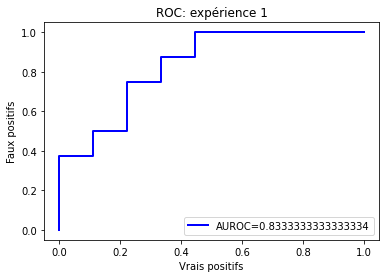

In [273]:
plt.figure()
plt.plot(fpr_exp1, tpr_exp1, color="blue", lw=2, label=f"AUROC={stats_exp_1['auroc']}")
plt.xlabel("Vrais positifs")
plt.ylabel("Faux positifs")
plt.title("ROC: expérience 1")
plt.legend(loc="lower right")
plt.show()

# 3.0 Régression logistique: expérience de cross-validation

In [274]:
# Expérience de cross-validation en régression logistique
count = 0
crossval_test_scores = pd.DataFrame()
crossval_train_scores = pd.DataFrame()

fpr_exp2 = []
tpr_exp2 = []
thr_exp2 = []

# Préparation des données
X_crossval = total_set.copy().drop(['responder', 'age', 'sex', 'VA_6months', 'elevated_edge'], axis=1)
normalise_data(X_crossval)
y_crossval = total_set['responder'].copy()

# Expérience de cross-validation
for n_exp in range(5):

    # Définition des splits
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=n_exp)
    groupes = folds.split(X_crossval, y_crossval)

    # Pour chaque split...
    for train_index, test_index in groupes:

        # Sélection du modèle
        model = LogisticRegressionCV(cv=10)

        # Initialisation des ensembles selon les splits
        X_train_CV, X_test_CV = X_crossval.iloc[train_index, :], X_crossval.iloc[test_index, :]
        y_train_CV, y_test_CV = y_crossval.iloc[train_index], y_crossval.iloc[test_index]

        # Entraînement
        model.fit(X_train_CV, y_train_CV)

        # Accumulation des données métriques
        test_stats, test_fpr, test_tpr, test_thr = tester_le_modele(model, X_test_CV, y_test_CV)
        train_stats, train_fpr, train_tpr, train_thr = tester_le_modele(model, X_train_CV, y_train_CV)
        print(".", end="")
        crossval_test_scores = pd.concat([crossval_test_scores, test_stats], axis=1)
        crossval_train_scores = pd.concat([crossval_train_scores, train_stats], axis=1)
        fpr_exp2.append(test_fpr)
        tpr_exp2.append(test_tpr)
        thr_exp2.append(test_thr)
        count += 1

# Mise en forme des résultats accumulés
crossval_test_scores = crossval_test_scores.transpose()
crossval_train_scores = crossval_train_scores.transpose()

stats_test_crossval = pd.DataFrame([crossval_test_scores.mean(axis=0, skipna=True), crossval_test_scores.std(axis=0, skipna=True)]).transpose()
stats_test_crossval.rename(columns={0:'Mean', 1: 'Std'}, inplace=True)

stats_train_crossval = pd.DataFrame([crossval_train_scores.mean(axis=0, skipna=True), crossval_train_scores.std(axis=0, skipna=True)]).transpose()
stats_train_crossval.rename(columns={0:'Mean', 1: 'Std'}, inplace=True)

print("\n")
display(Markdown("### Résultats de la crossvalidation sur 25 runs: training set"))
display(Markdown(stats_test_crossval.to_markdown()))
display(Markdown("### Résultats de la crossvalidation sur 25 runs: testing set"))
display(Markdown(stats_train_crossval.to_markdown()))

.........................



### Résultats de la crossvalidation sur 25 runs: training set

|       |     Mean |       Std |
|:------|---------:|----------:|
| acc   | 0.705933 | 0.0739464 |
| F1    | 0.705452 | 0.07543   |
| auroc | 0.810876 | 0.0563601 |
| SP    | 0.694615 | 0.150469  |
| SN    | 0.716667 | 0.120281  |
| NPV   | 0.721218 | 0.0778093 |
| PPV   | 0.711103 | 0.0937664 |

### Résultats de la crossvalidation sur 25 runs: testing set

|       |     Mean |       Std |
|:------|---------:|----------:|
| acc   | 0.750846 | 0.0227075 |
| F1    | 0.74416  | 0.027636  |
| auroc | 0.838251 | 0.016429  |
| SP    | 0.768827 | 0.0203099 |
| SN    | 0.7325   | 0.0406473 |
| NPV   | 0.746003 | 0.0285231 |
| PPV   | 0.756993 | 0.0193397 |

## 3.1 Statistiques pour l'expérience de crossvalidation: 25 runs au total

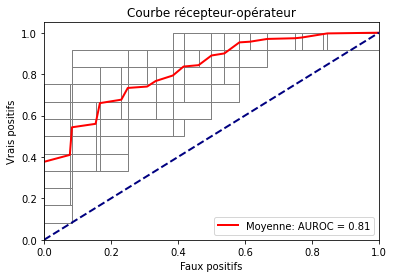

In [275]:
def construire_courbe_ROC_moyenne(fpr_list, tpr_list, thr_list):

    fpr_moyen = np.unique(np.concatenate([np.array(fpr_list[i]) for i in range(len(fpr_list))]))
    tpr_moyen = np.zeros_like(fpr_moyen)

    for i in range(len(fpr_list)):
        delta = np.interp(fpr_moyen, np.array(fpr_list[i]), np.array(tpr_list[i]))
        tpr_moyen += delta

    tpr_moyen /= len(fpr_list)
    return fpr_moyen, tpr_moyen

plt.close()
plt.figure()

# Bâtir les courbes pour chaque exécution
for i in range(len(fpr_exp2)):
    plt.plot(fpr_exp2[i], tpr_exp2[i], color="grey", lw=1)

fpr_moyen, tpr_moyen = construire_courbe_ROC_moyenne (fpr_exp2, tpr_exp2, thr_exp2)
plt.plot(fpr_moyen, tpr_moyen, color="red", lw=2, label=f"Moyenne: AUROC = {stats_test_crossval.at['auroc', 'Mean']:.2f}")

# Bâtir la courbe de référence
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

# Paramètres du graphe
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.title("Courbe récepteur-opérateur")
plt.legend(loc="lower right")

plt.show()